# Tree detection inference using SAM2

In [1]:
# Import required libraries
from pathlib import Path
import torch

from tree_detection_framework.constants import DATA_FOLDER
from tree_detection_framework.detection.SAM2_detector import SAMV2Detector
from tree_detection_framework.postprocessing.postprocessing import multi_region_NMS
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    visualize_dataloader,
)

/ofo-share/repos-amritha/conda/envs/sam-tdf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define constants
The behavior of this notebook can be changed by adjusting these values.

In [ ]:
# The path to a folder of raster images, e.g. orthomosaics stor
RASTER_FOLDER_PATH = Path(DATA_FOLDER, "emerald-point-ortho")
RASTER_FILE_PATH = Path(RASTER_FOLDER_PATH, "ortho.tif")
# Prediction file path
OUTPUT_PREDICTIONS_FILE_PATH = Path(
    DATA_FOLDER, "emerald-point-ortho-detectree2-predictions.gpkg"
)
# The size of the chips in pixels
CHIP_SIZE = 1024
# The stride between chips in pixels
CHIP_STRIDE = 768
# The spatial resolution that the data is sampled to in meters/pix
RESOLUTION = 0.05
# The number of samples in a batch
BATCH_SIZE = 4
# Any detections below this threshold will be discarded
MIN_CONFIDENCE_THRESHOLD = 0.3
# Detections that overlap more than this threshold will be suppressed
IOU_NMS_THESHOLD = 0.3

# How many tiles to show
N_VIS_TILES = 3

TREE_DETECTOR = "sam2"

# The device to use for inference, GPU or CPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Create a dataloader to generate samples

In [ ]:
dataloader = create_dataloader(
    raster_folder_path=RASTER_FOLDER_PATH,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    resolution=RESOLUTION,
    batch_size=BATCH_SIZE,
)

INFO:root:Units = Units.PIXELS
INFO:root:Stride = 768


Show example samples

In [ ]:
visualize_dataloader(dataloader, n_tiles=N_VIS_TILES)

Create a SAM2 detector model and get predictions

In [ ]:
detector = SAMV2Detector()
outputs = detector.predict(dataloader)

Plot the predictions for all overlapping tiles colored by the prediction confidence

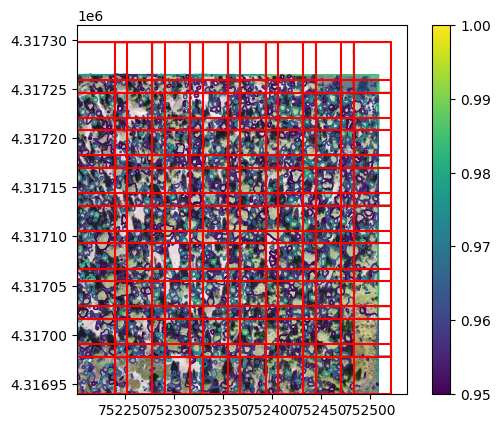

<Axes: >

In [6]:
outputs.plot(
    visualization_column="score", bounds_color="r", raster_file=RASTER_FILE_PATH
)

Show the prediction of just one tile without the raster

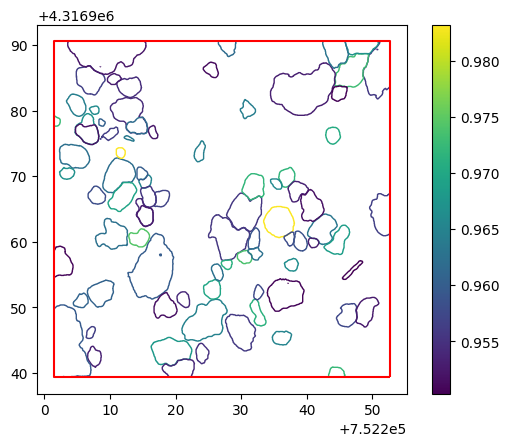

In [7]:
outputs.region_detections[0].plot(visualization_column="score", bounds_color="r")

Run nonmax suppression and across all the tiles and remove low-confidence detections

In [9]:
NMS_outputs = multi_region_NMS(
    outputs,
    confidence_column="score",
    threshold=IOU_NMS_THESHOLD,
    min_confidence=MIN_CONFIDENCE_THRESHOLD,
)

INFO:root:Bound have overlap, running across-region NMS


Show the result again after running NMS

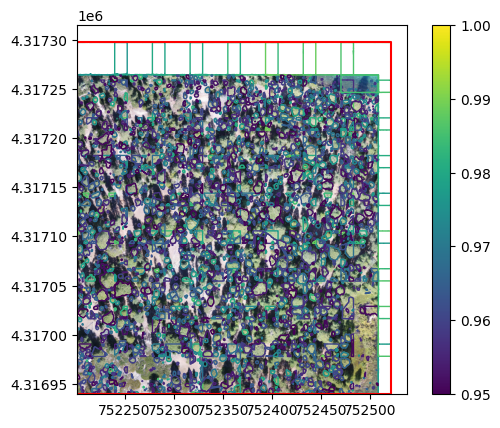

In [10]:
NMS_outputs.plot(
    visualization_column="score", bounds_color="r", raster_file=RASTER_FILE_PATH
)

Save out the predictions to a geospatial file

In [11]:
NMS_outputs.save(OUTPUT_PREDICTIONS_FILE_PATH)

2024-12-11 21:45:53,625 - INFO - Created 1,418 records
